In [43]:
import numpy as np
import yfinance as yf
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
import pandas as pd

# Set up


In [44]:
START = "2021-01-01"
END = "2025-01-01"
TICKER = "^GSPC"
TITLE = TICKER + " - " +(datetime.now()).strftime("%Y-%m-%d - %H:%M:%S")

In [45]:
data = pd.read_csv("data.csv")

# data = yf.download(TICKER,start=START, end=END,multi_level_index=False)

data["log_return"] = np.log(data["Close"] / data["Close"].shift(1))

data.dropna(inplace=True)

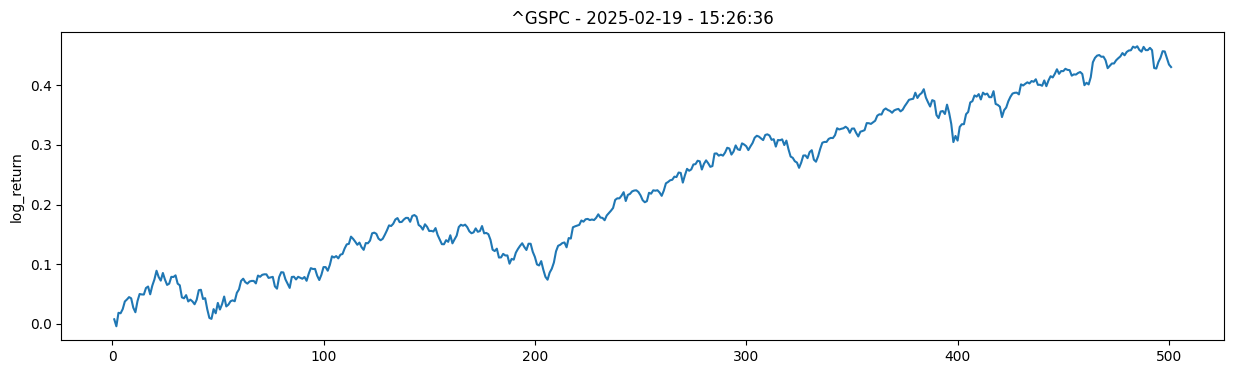

In [46]:
fig = plt.figure(figsize=(15,4))
sns.lineplot(data["log_return"].cumsum()).set_title(TITLE)
plt.show()

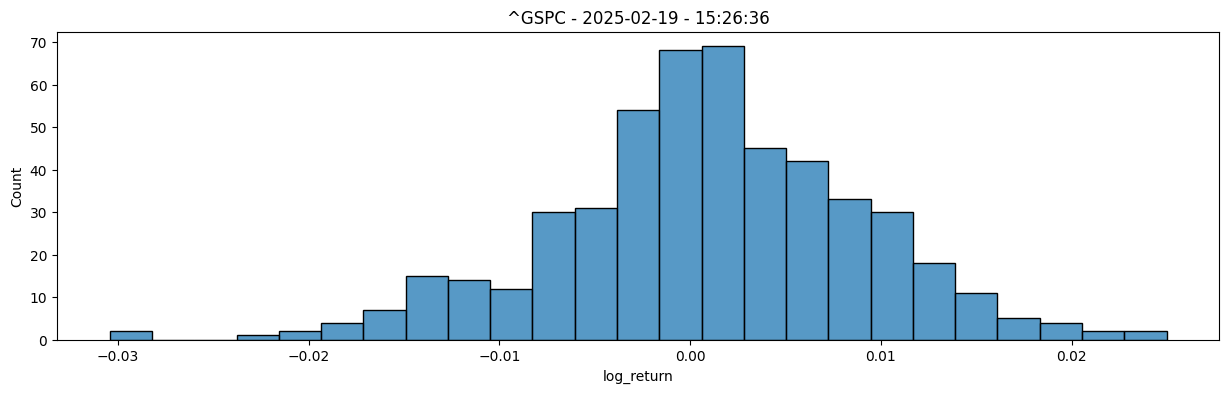

In [47]:
fig = plt.figure(figsize=(15,4))
sns.histplot(data["log_return"]).set_title(TITLE)
plt.show()

## SMA

In [48]:
def sma(data, t):
    return data.shift(1).rolling(t).mean()

In [49]:
Fast = 20
Slow = 50
Long = 200
data["SMA_fast"] = sma(data["Close"],Fast)
data["SMA_slow"] = sma(data["Close"],Slow)
data["SMA_long"] = sma(data["Close"],Long)

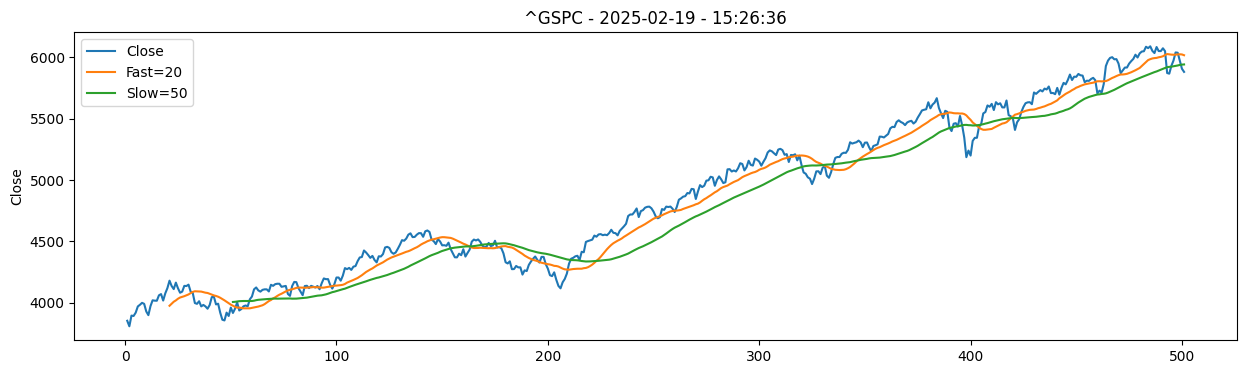

In [50]:
fig = plt.figure(figsize=(15,4))
ax1 = sns.lineplot(data["Close"],label="Close")
ax2 = sns.lineplot(data["SMA_fast"],label=f"{Fast=}")
ax3 = sns.lineplot(data["SMA_slow"],label=f"{Slow=}")
ax1.set_title(TITLE)
plt.legend()
plt.show()

In [51]:
data["bull"] = data["SMA_fast"] > data["SMA_slow"]

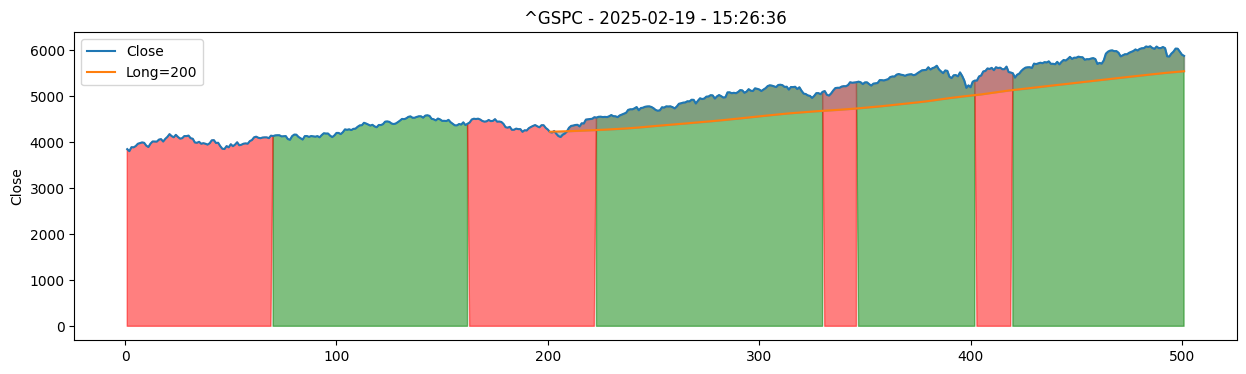

In [52]:
fig = plt.figure(figsize=(15,4))
plt.fill_between(data.index, data["Close"], 0, where=data["bull"],color="green",alpha=0.5,interpolate=True)
plt.fill_between(data.index, data["Close"], 0, where=~data["bull"],color="red",alpha=0.5,interpolate=True)
plt.fill_between(data.index, data["Close"], data["SMA_long"],color="grey",alpha=0.5,interpolate=True)
ax1 = sns.lineplot(data["Close"], label="Close")
ax1 = sns.lineplot(data["SMA_long"], label=f"{Long=}")
ax1.set_title(TITLE)
plt.show()

# Bull and bear markets

Text(0.5, 1.0, '^GSPC - 2025-02-19 - 15:26:36')

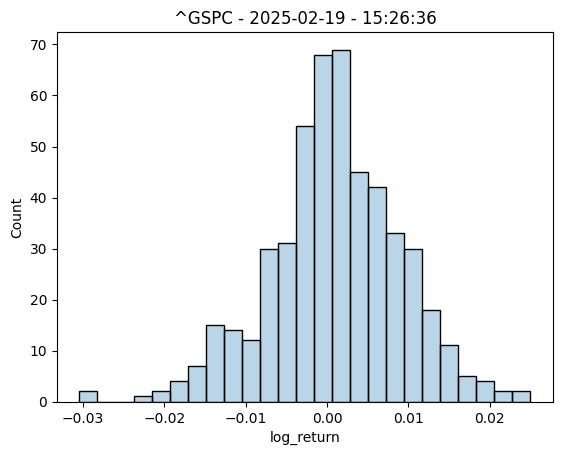

In [53]:
sns.histplot(data["log_return"],alpha=0.3).set_title(TITLE)

Text(0.5, 1.0, '^GSPC - 2025-02-19 - 15:26:36')

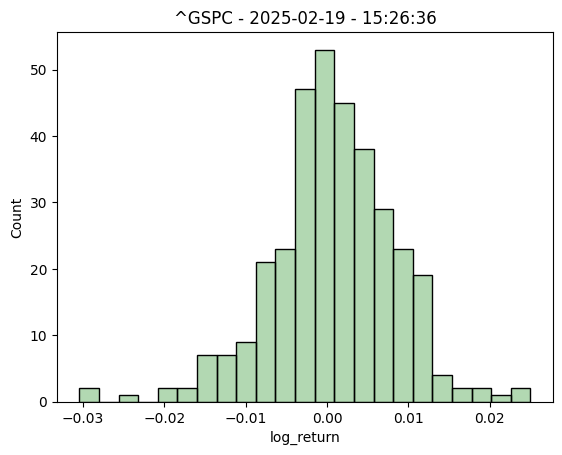

In [54]:
sns.histplot(data["log_return"].where(data["bull"]),color="green",alpha=0.3).set_title(TITLE)

Text(0.5, 1.0, '^GSPC - 2025-02-19 - 15:26:36')

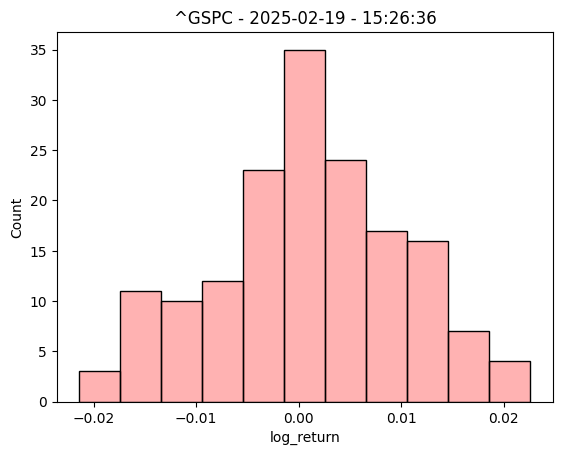

In [55]:
sns.histplot(data["log_return"].where(~data["bull"]),color="red",alpha=0.3).set_title(TITLE)

Text(0.5, 1.0, '^GSPC - 2025-02-19 - 15:26:36')

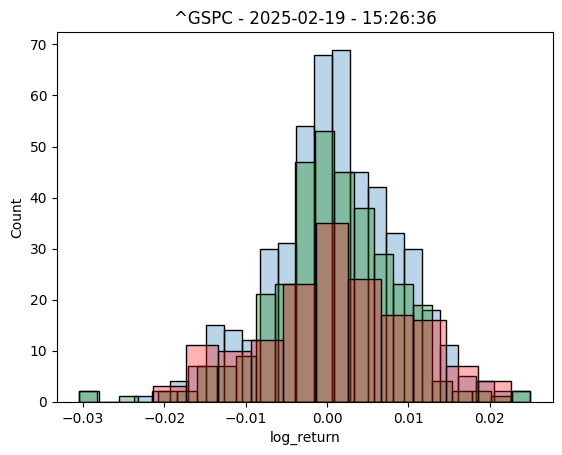

In [56]:
sns.histplot(data["log_return"],alpha=0.3).set_title(TITLE)
sns.histplot(data["log_return"].where(data["bull"]),color="green",alpha=0.3).set_title(TITLE)
sns.histplot(data["log_return"].where(~data["bull"]),color="red",alpha=0.3).set_title(TITLE)

# 1 - Descriptive statistics

In [57]:
from scipy import stats

In [58]:
def jarque_bera(data):
    # Reject Null if 0.05>
    return stats.jarque_bera(data.dropna()).pvalue


def describe_returns(data):
    mean = data.mean()
    std = data.std()
    skew = data.skew()
    kurt = data.kurt()
    jarque = jarque_bera(data)

    return pd.DataFrame({"Mean %" : [mean], "Standard deviation %": [std], "Skew": [skew], "Kurtosis": [kurt], "Jarque-bera p value":[jarque]})

In [59]:
both = describe_returns(data['log_return'])
bull = describe_returns(data['log_return'].where(data['bull']))
bear = describe_returns(data['log_return'].where(~data['bull']))

In [60]:
combined = pd.concat([both,bull,bear])
combined.index = ["Both", "Bull", "Bear"]
combined["Mean %"] *= 100
combined["Standard deviation %"] *= 100

round(combined.T,4)

,Both,Bull,Bear
Mean %,0.0859,0.0724,0.1141
Standard deviation %,0.8108,0.7567,0.9156
Skew,-0.2853,-0.4006,-0.1720
Kurtosis,0.7527,1.6462,-0.3532
Jarque-bera p value,0.0001,0.0000,0.4158


# Students t-test on Bull and bear markets

This is a test for the null hypothesis that 2 independent samples have identical average (expected) values. **This test assumes that the populations have identical variances by default.**

The p-value quantifies the probability of observing as or more extreme values assuming the null hypothesis, that the samples are drawn from populations with the same population means, is true. A p-value larger than a chosen threshold (e.g. 5% or 1%) indicates that our observation is not so unlikely to have occurred by chance. Therefore, we do not reject the null hypothesis of equal population means. If the p-value is smaller than our threshold, then we have evidence against the null hypothesis of equal population means.

ttest_ind underestimates p for unequal variances:

In [61]:
stats.ttest_ind(data["log_return"],data["log_return"].where(data["bull"]),nan_policy="omit").pvalue

np.float64(0.8081878403710501)

0.8>0.05 - Accept null 

In [62]:
stats.ttest_ind(data["log_return"],data["log_return"].where(~data["bull"]),nan_policy="omit").pvalue

np.float64(0.709493872061443)

0.71 > 0.05 - Accept null

# Type errors

In [63]:
true_positive = (data["bull"] & (data["log_return"] > 0)).value_counts().iloc[1]
true_negative = (~data["bull"] & (data["log_return"] < 0)).value_counts().iloc[1]

false_postive = (data["bull"] & (data["log_return"] < 0)).value_counts().iloc[1]
false_negative = (~data["bull"] & (data["log_return"] > 0)).value_counts().iloc[1]

# Precision

TP + (TP + FP)

In [64]:
true_positive / (true_positive + false_postive)

np.float64(0.5545722713864307)

# Accuracy

(TP + TN) / all

In [65]:
(true_positive + true_negative) / (true_positive + true_negative + false_negative + false_postive)

np.float64(0.5149700598802395)

## Balanced accuracy

In [66]:
TPR = true_positive / (true_positive + false_negative)
TNR = true_negative / (true_negative + false_postive)

(TPR + TNR) / 2

np.float64(0.4940853264382676)

# Recall

In [67]:
true_positive / (true_positive + false_negative)

np.float64(0.6714285714285714)

# F1 score

In [68]:
(2*true_positive) / (2*(true_positive + false_postive + false_negative))

np.float64(0.4361948955916473)

# Back testing

In [69]:
data = data[Long:]

In [ ]:
last = 0
#        [Date, Buy, Balance, Position]
equity = [(data.index[0],0,10_000,0)]
for index, row in data.iterrows():


    buy = 0
    position = equity[-1][3]
    balance = equity[-1][2]
    

    if row["bull"] and (not last) and row["Open"] > row["SMA_long"]: # Buy
        buy = 1
        position = balance // row["Open"]
        balance -= row["Open"] * position

    if not row["bull"] and last: # Sell
        buy = -1
        balance += row["Open"] * position
        position = 0

    equity.append((index, buy, balance, position))
    last = row["bull"]


In [71]:

equity = pd.DataFrame(equity,columns=["Date","buy","balance","position"])

equity = equity.set_index("Date")

data = data.join(equity)

data["value"] = (data["position"] * data["Close"]) + data["balance"]

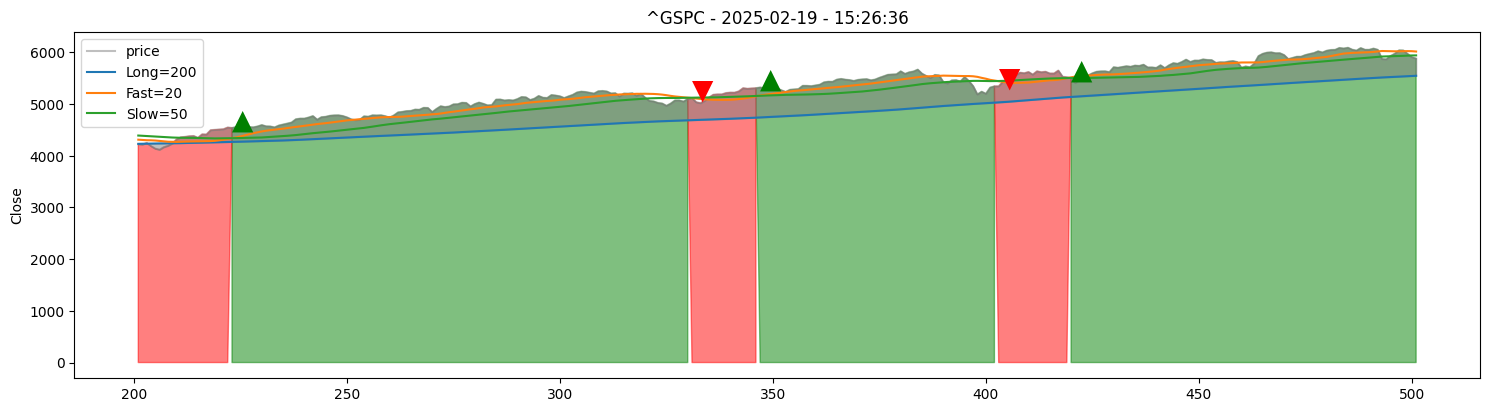

In [72]:
fig, ax1 = plt.subplots(figsize=(15,4))

plt.fill_between(data.index, data["Close"], 0, where=data["bull"],color="green",alpha=0.5,interpolate=True)
plt.fill_between(data.index, data["Close"], 0, where=~data["bull"],color="red",alpha=0.5,interpolate=True)
plt.fill_between(data.index, data["Close"], data["SMA_long"],color="grey",alpha=0.5,interpolate=True)

ax1 = sns.lineplot(data["Close"],color="grey",alpha=0.5, label="price")
ax1 = sns.lineplot(data["SMA_long"],label=f"{Long=}")
ax1 = sns.lineplot(data["SMA_fast"], label=f"{Fast=}")
ax1 = sns.lineplot(data["SMA_slow"], label=f"{Slow=}")
# sns.lineplot(data["value"])

df_filt = data[data["buy"] != 0.0]

for index, value in df_filt.iterrows():
    if value["buy"] == -1.0:
        ax1.annotate("▼",(index,value["Close"]), color="red",fontsize=20)
    if value["buy"] == 1.0:
        ax1.annotate("▲",(index,value["Close"]), color="green",fontsize=20)

fig.tight_layout()
ax1.set_title(TITLE)
plt.show()

In [73]:
# data.to_excel("test.xlsx")

In [74]:
data["log_return"].sum()

np.float64(0.3056831545983566)

In [75]:
data["value_log_return"] = np.log((data["value"] / data["value"].shift(1)))

data["value_log_return"].sum()

np.float64(0.18067012883295663)

<Axes: title={'center': '^GSPC - 2025-02-19 - 15:26:36'}, ylabel='value_log_return'>

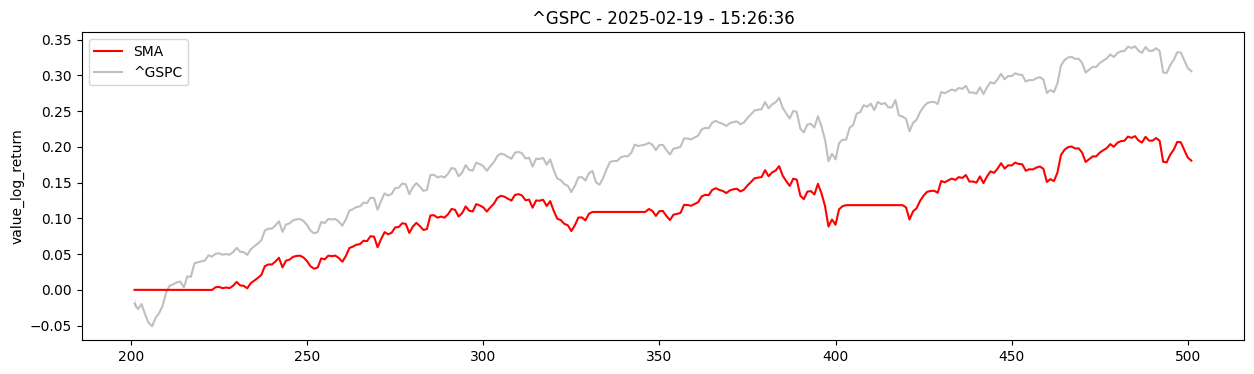

In [76]:
fig, ax1 = plt.subplots(figsize=(15,4))
sns.lineplot(data["value_log_return"].cumsum(),dashes=False,label="SMA",color="red").set_title(TITLE)
sns.lineplot(data["log_return"].cumsum(),dashes=False,label=TICKER,alpha=0.5,color="grey",zorder=0)

# Drawdown

<Axes: title={'center': '^GSPC - 2025-02-19 - 15:26:36'}, ylabel='value_log_return'>

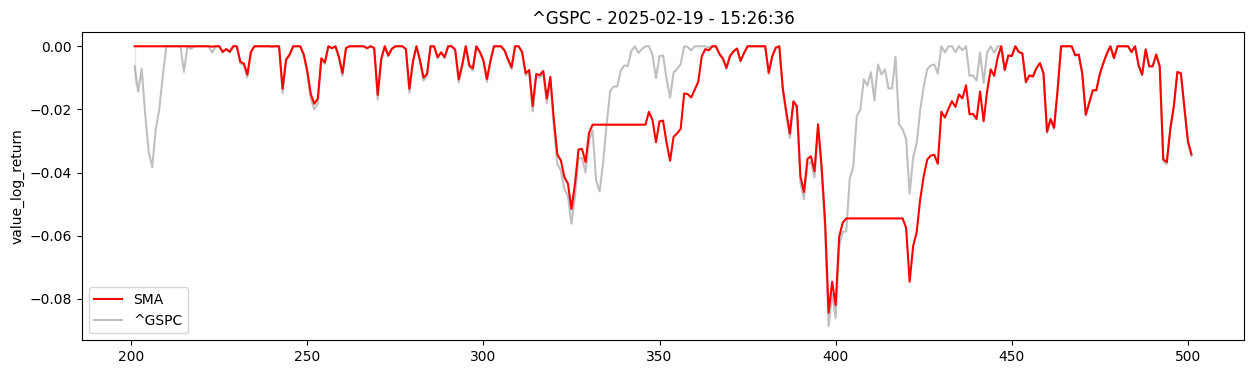

In [77]:
fig, ax1 = plt.subplots(figsize=(15,4))
sns.lineplot(data["value_log_return"].cumsum() - data["value_log_return"].cumsum().cummax(),dashes=False,label="SMA",color="red").set_title(TITLE)
sns.lineplot(data["log_return"].cumsum() - data["log_return"].cumsum().cummax(),dashes=False,label=TICKER, alpha=0.5,color="grey",zorder=0)

# Portfolio stats (annual)

In [78]:
data["log_return"].sum() / 5

np.float64(0.06113663091967132)

In [79]:
data["value_log_return"].sum() / 5

np.float64(0.036134025766591325)

In [80]:
data["log_return"].std() * np.sqrt(252*5)

np.float64(0.28124746239065523)

In [81]:
data["value_log_return"].std() * np.sqrt(252*5)

np.float64(0.23494525362161822)

In [82]:
((data["log_return"].mean()) / (data["log_return"].std())) * np.sqrt(252)

np.float64(2.027969849502346)

In [83]:
(data["value_log_return"].mean() / data["value_log_return"].std()) * np.sqrt(252)

np.float64(1.4395896837699362)

In [ ]:
from dataclasses import dataclass,field
from random import randint

from numpy import quantile

@dataclass
class Trade:
    trade_id: int
    date: datetime
    long: bool
    entry_price: float
    quantity: int
    exit_price: float = None
    exit_date: datetime = None
    is_open: bool = True

    def close_trade(self, date, row):
        self.exit_price = row["Close"]
        self.exit_date = date
        self.is_open = False

    @property
    def entry_value(self):
        return self.entry_price * self.quantity
    
    @property
    def exit_value(self):
        return self.exit_price * self.quantity

class Strategy:
    def __init__(self):
        pass
    

    def logic(self, index, data):
        # logic
        quantity = 0

        
        # return Trade(randint(0,15999),index,position,data["Close"],quantity)
        pass


class Backtest:
    def __init__(self, strategy, data):
        self.account = 10_000 # Any number
        self.positions = [] # List of open trades
        self.history = [] # List of closed trades
        self.strategy = strategy
        self.data = data

    def backtest(self):
        
        for index, row in self.data.iterrows(): # Provide an expanding window
            
            trade = self.strategy.trade(index, row)

            if not trade is None:
                # If there is a trade
                if trade in self.positions:
                    # If the trade already exists it needs to be closed
                    self.positions.remove(trade)
                    # trade.exit_price = row["Close"]
                    self.history.append(trade.close_trade(index,row))

                else:
                    # This is a new trade and needs to be added
                    self.positions.append(trade)

                # credit/debit account
                if trade.is_open():
                    factor = -1
                else:
                    factor = 1
                
                if trade.long:
                    self.account -= trade.entry_price 
                else:
                    self.account += trade.entry_price 

            



        